In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import copy 
from imblearn.over_sampling import SMOTE 
from datetime import datetime
import datetime
from sklearn import metrics
from pathlib import Path
import seaborn as sns

In [39]:
path = Path('DataSet')

df_train = pd.read_csv(path/'Train.csv', low_memory=False)
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
test_id_code = df_test.id_code

print(df_train.shape)
print(df_test.shape)
df_train.head()

(1284, 19)
(964, 18)


,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,mean_halt_times_source,country_code_destination,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,current_day,is_weekend
0,isfywypmkqqhyft,2016-07-27,08:05:51 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
1,mqsfxyvuqpbwomk,2016-07-27,08:06:11 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
2,alspwwtbdvqsgby,2016-07-27,08:08:57 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
3,szitxhhqduyrqpg,2016-07-27,08:09:08 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
4,krisdqzczivvwcp,2016-07-27,08:11:01 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False


<h3>Data preprocessing</h3>

In [40]:
Target_Volume = {"high": 2, "medium": 1, "low": 0 }
Predict_Volume = {2: "high", 1: "medium", 0: "low" }
is_weekend = {"False": 0 , "True": 1}

def ChangeTime(x):
    if x != "":
        dt = datetime.datetime.strptime(x, "%I:%M:%S %p")
        seconds = dt.second + dt.minute * 60 + dt.hour * 60 * 60
        #print(seconds)
        return int(seconds)
    else:
        return ""

def ConvertStations(x):
    if x != "":
        x = x.replace("station$", "")
        return int(x)
    else:
        return ""

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_station_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def Prepare(dataset):
    dataset["current_time"] = dataset["current_time"].apply(ChangeTime)
    dataset["source_name"] = dataset["source_name"].apply(ConvertStations)
    dataset["destination_name"] = dataset["destination_name"].apply(ConvertStations)
    dataset["is_weekend"] = dataset["is_weekend"].apply(lambda x: is_weekend[str(x)])
    dataset = dataset.sort_values(by=['current_date', 'current_time'])
    return dataset

In [41]:
df_train = Prepare(df_train)
df_test = Prepare(df_test)
df_train["target"] = df_train["target"].apply(lambda x: Target_Volume[x])    

In [42]:
def calculate_empty(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [43]:
calculate_empty(df_train).head()

,Total,Percent
mean_halt_times_destination,33,0.025701
latitude_destination,33,0.025701
longitude_destination,33,0.025701
country_code_destination,33,0.025701
latitude_source,1,0.000779


<h3>A. Haversine Distance Between the Two Lat/Lons:</h3>

In [44]:
def fill_all_empty(dataset):
    dataset["longitude_destination"] = dataset["longitude_destination"].fillna(0)
    dataset["latitude_destination"] = dataset["latitude_destination"].fillna(0)
    dataset["longitude_source"] = dataset["longitude_source"].fillna(0)
    dataset["latitude_source"] = dataset["latitude_source"].fillna(0)
    dataset["mean_halt_times_destination"] = dataset["mean_halt_times_destination"].fillna(0)
    dataset["mean_halt_times_source"] = dataset["mean_halt_times_source"].fillna(0)
    
    dataset["country_code_source"] = dataset["country_code_source"].fillna("None")
    dataset["country_code_destination"] = dataset["country_code_destination"].fillna("None")
    
    dataset["station_diff"] = np.abs(dataset["source_name"] - dataset["destination_name"])
    dataset.loc[:, 'center_latitude'] = (dataset['latitude_source'].values + dataset['latitude_destination'].values) / 2
    dataset.loc[:, 'center_longitude'] = (dataset['longitude_source'].values + dataset['longitude_destination'].values) / 2
    
    # B. Manhattan Distance Between the two Lat/Lons:
    dataset.loc[:, 'dummy_station_distance'] = dummy_station_distance(dataset['latitude_source'].values, dataset['longitude_source'].values, 
                                                     dataset['latitude_destination'].values,  dataset['longitude_destination'].values)
    
    return dataset


df_train = fill_all_empty(df_train)
df_test = fill_all_empty(df_test)

In [45]:
print("Train X", df_train.shape)
print("Test X", df_test.shape)

Train X (1284, 23)
Test X (964, 22)


In [46]:
def create_time_difference(dataset):
    dataset["delay_time"] = 0
    _dates = dataset["current_date"].unique()
    final_data = pd.DataFrame()
    #print(_dates)
    for date in _dates:
        dataset_block = dataset.loc[dataset["current_date"] == date]
        delay_time = dataset_block["current_time"].diff().values
        dataset.loc[dataset["current_date"] == date, "delay_time"] = delay_time
        """
        dataset_count_df = pd.DataFrame({'current_date' : dataset_block["current_date"].values, 
                                       'delay_time': delay_time})
        final_data = pd.concat([final_data, dataset_count_df], ignore_index=True)
        print("final_data X", final_data.shape)
        del dataset_count_df
        """
    dataset["delay_time"] = dataset["delay_time"].fillna(0)
    del final_data
    return dataset

df_train = create_time_difference(df_train)
df_test = create_time_difference(df_test)

In [47]:
print("Train X", df_train.shape)
print("Test X", df_test.shape)
df_train.head()

Train X (1284, 24)
Test X (964, 23)


,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,...,mean_halt_times_destination,current_year,current_week,current_day,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time
0,isfywypmkqqhyft,2016-07-27,72351,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,0.0
1,mqsfxyvuqpbwomk,2016-07-27,72371,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,20.0
2,alspwwtbdvqsgby,2016-07-27,72537,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,166.0
3,szitxhhqduyrqpg,2016-07-27,72548,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,11.0
4,krisdqzczivvwcp,2016-07-27,72661,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,113.0


In [48]:
df_train.head()

,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,...,mean_halt_times_destination,current_year,current_week,current_day,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time
0,isfywypmkqqhyft,2016-07-27,72351,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,0.0
1,mqsfxyvuqpbwomk,2016-07-27,72371,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,20.0
2,alspwwtbdvqsgby,2016-07-27,72537,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,166.0
3,szitxhhqduyrqpg,2016-07-27,72548,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,11.0
4,krisdqzczivvwcp,2016-07-27,72661,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,113.0


<h3>Normalization</h3>

In [49]:
def normalize_data(dataset):
    dataset["current_time"] = StandardScaler().fit_transform(np.array(dataset['current_time']).reshape(-1, 1))
    dataset["source_name"] = StandardScaler().fit_transform(np.array(dataset['source_name']).reshape(-1, 1))
    dataset["destination_name"] = StandardScaler().fit_transform(np.array(dataset['destination_name']).reshape(-1, 1))
    dataset["mean_halt_times_destination"] = StandardScaler().fit_transform(np.array(dataset['mean_halt_times_destination']).reshape(-1, 1))
    dataset["mean_halt_times_source"] = StandardScaler().fit_transform(np.array(dataset['mean_halt_times_source']).reshape(-1, 1))
    dataset["station_diff"] = StandardScaler().fit_transform(np.array(dataset['station_diff']).reshape(-1, 1))
    dataset["dummy_station_distance"] = StandardScaler().fit_transform(np.array(dataset['dummy_station_distance']).reshape(-1, 1))
    dataset["delay_time"] = StandardScaler().fit_transform(np.array(dataset['delay_time']).reshape(-1, 1))
    dataset["center_latitude"] = StandardScaler().fit_transform(np.array(dataset['delay_time']).reshape(-1, 1))
    
    dataset["halt_times_diff"] = np.abs(dataset["mean_halt_times_source"] - dataset["mean_halt_times_destination"])
    return dataset

df_train = normalize_data(df_train)
df_test = normalize_data(df_test)

In [50]:
#df_train.groupby(["current_date"])["train_name"].nunique()
def other_feature_engineering(dataset):
    train_count_df = pd.DataFrame({'total_train_count' : dataset.groupby( [ "current_date"] )["train_name"].count()}).reset_index()
    train_count_df["total_train_count"] = StandardScaler().fit_transform(np.array(train_count_df['total_train_count']).reshape(-1, 1))
    dataset = pd.merge(dataset, train_count_df, on='current_date', how='left')
    del train_count_df
    return dataset

df_train = other_feature_engineering(df_train)
df_test = other_feature_engineering(df_test)

In [51]:
#df_train.to_csv("tempsave.csv")

In [52]:
#df_train["current_time"]

In [53]:
df_train.describe()

,current_time,source_name,destination_name,target,longitude_source,latitude_source,mean_halt_times_source,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time,halt_times_diff,total_train_count
count,1.284000e+03,1.284000e+03,1.284000e+03,1284.000000,1284.000000,1284.000000,1.284000e+03,1284.000000,1284.000000,1.284000e+03,1284.0,1284.000000,1284.000000,1.284000e+03,1.284000e+03,1284.000000,1.284000e+03,1.284000e+03,1284.000000,1284.000000
mean,1.390373e-16,5.421416e-17,-1.036727e-16,0.890966,4.289138,50.895006,5.559762e-17,4.188345,49.615761,3.886645e-16,2016.0,36.781153,0.146417,-7.142089e-17,1.265862e-16,4.238741,5.317657e-18,1.335035e-16,1.064768,1.098788
std,1.000390e+00,1.000390e+00,1.000390e+00,0.841599,0.565119,1.436314,1.000390e+00,0.876005,8.066826,1.000390e+00,0.0,3.175253,0.353662,1.000390e+00,1.000390e+00,0.610943,1.000390e+00,1.000390e+00,0.878328,1.118219
min,-2.700968e+00,-1.674902e+00,-1.607969e+00,0.000000,-0.126061,0.000000,-1.213789e+00,0.000000,0.000000,-1.125917e+00,2016.0,30.000000,0.000000,-7.301949e-01,-3.976179e-01,0.097505,-2.000011e-01,-3.976179e-01,0.001894,-0.866857
25%,-9.918693e-01,-8.472319e-01,-7.963126e-01,0.000000,4.039653,50.845658,-8.709059e-01,3.922155,50.835707,-8.530692e-01,2016.0,36.000000,0.000000,-6.747121e-01,-3.953732e-01,4.023603,-1.892122e-01,-3.953732e-01,0.241978,0.214056
50%,2.288845e-01,-4.940925e-01,-4.500058e-01,1.000000,4.360846,50.896456,-4.248307e-01,4.356801,50.882280,-4.270402e-01,2016.0,38.000000,0.000000,-5.429403e-01,-3.393595e-01,4.356028,-1.749649e-01,-3.393595e-01,0.872826,0.949077
75%,7.274210e-01,1.221944e+00,1.232829e+00,2.000000,4.482785,51.056365,8.306319e-01,4.482785,51.035896,6.663182e-01,2016.0,39.000000,0.000000,2.130138e-01,-1.123289e-01,4.536333,-1.449160e-01,-1.123289e-01,1.656434,1.900280
max,1.939927e+00,1.884080e+00,1.882154e+00,2.000000,5.982265,51.925093,1.785748e+00,6.958823,52.379128,1.792600e+00,2016.0,40.000000,1.000000,3.743111e+00,1.223570e+01,5.915149,6.152910e+00,1.223570e+01,2.954080,3.283849


Skewness: -0.172598
Kurtosis: -0.915730


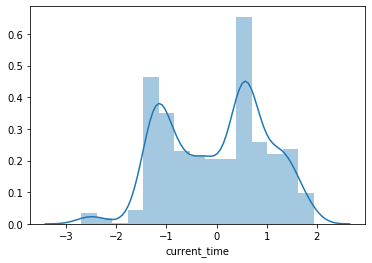

In [54]:
sns.distplot(df_train['current_time']);
print("Skewness: %f" % df_train['current_time'].skew())
print("Kurtosis: %f" % df_train['current_time'].kurt())

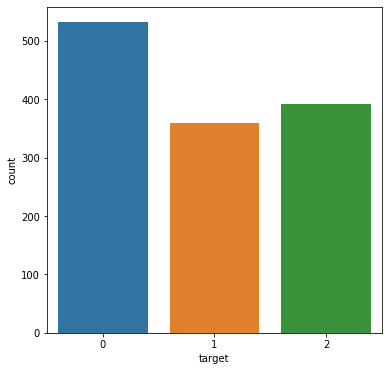

In [55]:
plt.figure(figsize=(6, 6))
sns.countplot(x="target", data=df_train)

In [56]:
def remove_unwanted_features(dataset):
    dataset = dataset.drop(["id_code", "current_date"], axis=1)
    dataset = dataset.drop(["current_year", "current_week"], axis=1)
    #dataset = dataset.drop(["longitude_source", "latitude_source", "longitude_destination", "latitude_destination"], axis=1)
    return dataset

df_train = remove_unwanted_features(df_train)
df_test = remove_unwanted_features(df_test)

<h3>Heat map</h3>

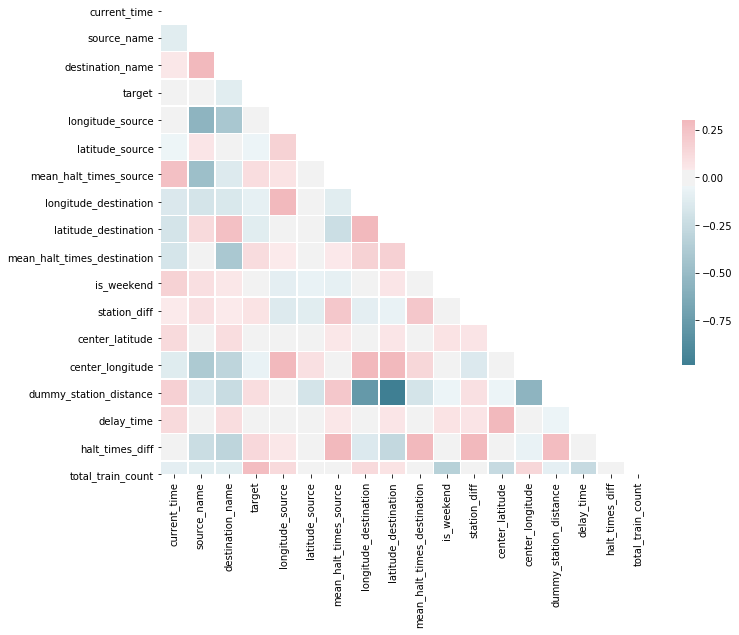

In [57]:
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [58]:
#hello
print("Train X", df_train.shape)
print("Test X", df_test.shape)

Train X (1284, 22)
Test X (964, 21)


In [59]:
mergedata = pd.concat([df_train, df_test], sort=False)
mergedata_pandas = pd.get_dummies(mergedata)

df_train = mergedata_pandas[:df_train.shape[0]]
df_test = mergedata_pandas[df_train.shape[0]:]

y = df_train.target # Target variable
X = df_train.drop(["target"], axis=1)
df_test = df_test.drop(["target"], axis=1)

In [60]:
#sns.pairplot(df_train)
print("Train X", X.shape)
print("Test X", df_test.shape)

Train X (1284, 901)
Test X (964, 901)


In [61]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=30)

<h3>Over Sampling</h3>

In [62]:
sm = SMOTE(random_state = 42) 
X, y = sm.fit_resample(X, y) 

#X_train, y_train = ADASYN().fit_resample(X, y)

In [63]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
model = LogisticRegression(max_iter=4000, solver='lbfgs', multi_class='auto')

In [64]:
#sns.pairplot(df_train)
print("Train SMOTE X", X.shape)

Train SMOTE X (1596, 901)


In [65]:
num_splits = 10
skf = StratifiedKFold(n_splits= num_splits, random_state= 42, shuffle=True)

In [66]:
y_test_pred = np.zeros((df_test.shape[0],))

y_valid_scores = []

X_TRAIN = X.copy()
Y_TRAIN = y.copy()
#X_TRAIN = X_TRAIN.reindex()
#Y_TRAIN = Y_TRAIN.reindex()

fold_cnt = 1
for train_index, test_index in skf.split(X_TRAIN,Y_TRAIN):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X_TRAIN[train_index], X_TRAIN[test_index]
    y_train, y_valid = Y_TRAIN[train_index], Y_TRAIN[test_index]
    
    #evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    # fit the model with data
    model.fit(X_train, y_train)
    
    y_pred_valid = np.abs(model.predict(X_valid))
    
    y_pred = np.abs(model.predict(df_test))
    
    y_valid_scores.append(f1_score(y_valid, y_pred_valid, average='weighted'))
    
    y_test_pred += y_pred
    
#Normalize test predicted probability
y_test_pred /= num_splits

FOLD ....  1
TRAIN: [   0    1    2 ... 1592 1593 1594] TEST: [   5    9   23   34   44   49   51   58   59   81   89  112  119  120
  131  135  136  139  145  146  152  154  160  177  217  223  234  243
  257  267  270  285  288  296  313  314  326  334  336  340  372  378
  385  395  408  412  424  426  488  492  500  529  548  559  575  576
  586  592  601  602  617  645  646  656  683  686  687  707  716  718
  724  728  744  757  760  764  793  810  816  853  860  871  874  894
  895  900  952  956  964  987  991 1013 1018 1019 1030 1048 1049 1052
 1059 1064 1065 1069 1070 1071 1076 1080 1084 1091 1116 1120 1137 1143
 1149 1153 1171 1174 1192 1213 1214 1216 1220 1234 1249 1264 1272 1275
 1303 1312 1313 1314 1347 1349 1358 1366 1376 1382 1399 1407 1409 1415
 1457 1472 1481 1488 1489 1490 1491 1514 1519 1520 1521 1523 1526 1530
 1531 1535 1552 1556 1561 1574 1590 1595]
FOLD ....  2
TRAIN: [   0    1    3 ... 1593 1594 1595] TEST: [   2   18   28   32   56   61   65   68   72   84   

In [67]:
y_valid_scores

[0.639949001320387,
 0.6603794958935145,
 0.6640201847071994,
 0.683811542635072,
 0.6612460638776427,
 0.6501930833795614,
 0.7110971013883635,
 0.6398292557455644,
 0.6414411534611406,
 0.6139764996907854]

In [68]:
print("Average validation_score: ",np.mean(y_valid_scores))

Average validation_score:  0.6565943382099231


In [69]:
y_test_pred

array([0. , 0.1, 1. , 0.9, 1. , 1. , 1. , 1. , 1.5, 0. , 0.7, 0. , 1. ,
       1.7, 0. , 1.8, 0. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 0. ,
       0.9, 1. , 2. , 0. , 0. , 0.5, 0.3, 0.3, 2. , 0.9, 0. , 0. , 0.1,
       0.7, 1. , 1. , 2. , 1. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 1.9,
       1.2, 1.3, 1.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. ,
       1.9, 1. , 1. , 1. , 2. , 0.4, 0. , 2. , 0. , 0. , 0. , 0. , 0. ,
       0. , 1.3, 1.3, 0. , 0. , 0. , 0. , 1.9, 0. , 1. , 1. , 1.6, 0. ,
       2. , 1. , 1.9, 0. , 1.6, 1.4, 1.2, 1.8, 1.8, 1.8, 2. , 2. , 1.4,
       1. , 1.8, 0.2, 1. , 1.9, 0. , 0. , 0. , 0. , 1.3, 1.2, 0. , 0. ,
       0. , 2. , 2. , 0. , 2. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.9,
       0.2, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.9, 1.9, 0. , 1. ,
       0. , 1. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 1.9, 0. , 1. , 1.1,
       1.3, 1.9, 1. , 1. , 2. , 1. , 1.9, 1.9, 1.4, 1. , 1. , 0.2, 0. ,
       0.9, 0.2, 1. , 1. , 0.2, 1. , 0.7, 1. , 1. , 1. , 1. , 2.

In [73]:
def ConvertOutput(x):
    x_ = x
    if x > 0.4 and x < 1.4:
        x_ = 1
    elif x > 1.4:
        x_ = 2
    else:
        x_ = 0    
    return x_

In [74]:
submission = pd.DataFrame({'id_code' : test_id_code.values, 'target' : y_test_pred})
submission['target'] = submission['target'].apply(ConvertOutput)    
submission['target'] = submission['target'].astype('int64', copy=False)
submission['target'] = submission['target'].apply(lambda x: Predict_Volume[x])    
submission.head()

,id_code,target
0,mckbezdplrukagl,low
1,agxwrnbmzbyxsjg,low
2,iqjojyewdyfshtj,medium
3,hssqexnzirioaag,medium
4,lublknpfraiznhr,medium


In [75]:
submission.to_csv("submission_v5.csv", index=False)